In [6]:
import pandas as pd
import numpy as np
import os
from utils import *
import cvxpy as cp
from datetime import timedelta


In [29]:
score_path = 'result_GRU.parquet'
startdate = '2015-01-01'
enddate = '2024-10-10'
chosen_index = '000852.SH'
barra_limit = 0.3
trade_freq= 5


In [39]:
# get prediction
score_df = pd.read_parquet(score_path)
score_df.reset_index(inplace=True)
score_df['Date'] = pd.to_datetime(score_df['Date'])
score_df = score_df[['Date', 'Symbol', 'pred']]
score_df.columns = ['Date', 'Symbol', 'pred']
score_df

,Date,Symbol,pred
0,2012-01-10,000001.SZ,-0.000394
1,2012-01-10,000002.SZ,0.028171
2,2012-01-10,000004.SZ,0.001217
3,2012-01-10,000005.SZ,0.000947
4,2012-01-10,000006.SZ,0.000703
...,...,...,...
10476544,2024-10-08,688799.SH,-0.005385
10476545,2024-10-08,688800.SH,-0.003066
10476546,2024-10-08,688819.SH,-0.008622
10476547,2024-10-08,688981.SH,-0.002772


In [5]:
# get return data
return_df = get_price([],startdate, enddate)
return_df = return_df.stack().reset_index().rename(columns={0:'vwap'})
# 5d forward price
return_df['vwap_next'] = return_df.groupby('Symbol')['vwap'].shift(-5)
# if vwap_next is nan, fill with vwap
return_df['vwap_next'].fillna(return_df['vwap'], inplace=True)
return_df['Date'] = pd.to_datetime(return_df['Date'])


# calculate 5d forward return
return_df['5d_forward_return'] = return_df['vwap_next'] / return_df['vwap'] - 1

return_df

In [38]:
score_df = pd.merge(score_df, return_df.drop('vwap_next', axis=1), on=['Date', 'Symbol'], how='left')
score_df.sort_values(['Date', 'Symbol'], inplace=True)
# score_df['vwap_next'] = score_df.groupby('Symbol')['vwap'].shift(-1)
score_df.dropna(subset='5d_forward_return', inplace=True) # there could be problem

# for each day, keep the top 100 stocks based on pred
test = score_df
test['rank'] = test.groupby('Date')['pred'].rank(ascending=False, method='first')
test = test[test['rank']<=100]

# get average return 
test.groupby('Date')['5d_forward_return'].mean().plot()

KeyError: ['5d_forward_return']

In [37]:
test.groupby('Date')['5d_forward_return']

In [32]:
rtn = test.groupby('Date')['5d_forward_return'].mean()
rtn[::5].describe()
# (rtn[::5]+1).cumprod().plot()

count    440.000000
mean       0.029501
std        0.045683
min       -0.168649
25%        0.005461
50%        0.026306
75%        0.047594
max        0.361593
Name: 5d_forward_return, dtype: float64

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  3.,  6.,  2.,  5.,
        14., 23., 34., 49., 60., 50., 61., 47., 26., 17., 11.,  6.,  5.,
         4.,  3.,  2.,  2.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.1686486 , -0.15804377, -0.14743893, -0.1368341 , -0.12622927,
        -0.11562444, -0.1050196 , -0.09441477, -0.08380994, -0.07320511,
        -0.06260027, -0.05199544, -0.04139061, -0.03078578, -0.02018094,
        -0.00957611,  0.00102872,  0.01163355,  0.02223839,  0.03284322,
         0.04344805,  0.05405289,  0.06465772,  0.07526255,  0.08586738,
         0.09647222,  0.10707705,  0.11768188,  0.12828671,  0.13889155,
         0.14949638,  0.16010121,  0.17070604,  0.18131088,  0.19191571,
         0.20252054,  0.21312537,  0.22373021,  0.23433504,  0.24493987,
         0.2555447 ,  0.26614954,  0.27675437,  0.2873592 ,  0.29796403,
         0.30856887,  0.3191737 ,  0.32977853,  0.34038337,

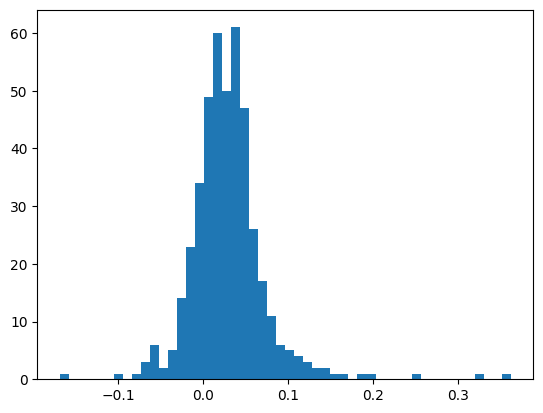

In [33]:
plt.hist(rtn[::5], bins=50)